In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!pip install timm
!pip install fastai

     |████████████████████████████████| 431 kB 37.2 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 28.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.2 MB 23.3 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 7.7 MB/s  eta 0:00:01
     |████████████████████████████████| 9.9 MB 32.4 MB/s eta 0:00:01
     |████████████████████████████████| 636 kB 42.4 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 72.2 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 67.2 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 67.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.8 MB/s  eta 0:00:01
     |████████████████████████████████| 13.7 MB 61.5 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 11.0 MB/s eta 0:00:01


In [28]:
import timm
from timm import create_model

In [45]:
seed = 999
#set_seed(seed, reproducible=True)
IMG_SIZE = 224
BATCH_SIZE = 14
N_FOLDS = 5
NUM_WORKERS = 8

In [46]:
import torch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [47]:
#!rm -rf /workspace/dataset/sick/dataset/*.ipynb_checkpoints
!rm -rf `find -type d -name .ipynb_checkpoints`

In [48]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
transforms = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize(IMG_SIZE),
#     transforms.CenterCrop(10),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
)

img_data = ImageFolder(root="/workspace/dataset/sick/dataset",
                      transform = transforms)


In [49]:
set(img_data.targets), img_data.classes

({0, 1, 2, 3, 4}, ['노균병', '녹병', '잎말이', '잿빛곰팡이병', '정상'])

In [51]:
for i in img_data.imgs:
    print(i)
    break

('/workspace/dataset/sick/dataset/노균병/ddd (1).jpeg', 0)


In [52]:
import pandas as pd

df = {
    "path" : [x[0][10:] for x in img_data.imgs],
    "label" : img_data.targets,
}
df = pd.DataFrame(df)
len(df)

768

In [53]:
from sklearn.utils import shuffle
train = shuffle(df)

In [54]:
set(train["label"]) #,  set(test["label"])

{0, 1, 2, 3, 4}

In [55]:
n = len(img_data.classes)

In [56]:
nums =[0]*n
for t in train['label']:
    nums[t]+=1
nums

[77, 59, 77, 196, 359]

In [57]:
from fastai.vision.all import *

In [64]:
data = ImageDataLoaders.from_df(train, #pass in train DataFrame
                                valid_pct=0.2, #90-10 train-validation random split
                           #valid_col='is_valid', #
                           seed=seed, #seed
                           fn_col='path', #filename/path is in the second column of the DataFrame
                           label_col='label', #label is in the first column of the DataFrame
                           blocks=(ImageBlock, MultiCategoryBlock), #The type of target
                           bs=BATCH_SIZE, #pass in batch size
                           num_workers=NUM_WORKERS, #4
                           item_tfms=Resize(IMG_SIZE), #pass in item_tfms
                           batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms


In [65]:
#print(img_data.class_to_idx)
#data.show_batch()

In [66]:
# check available batch size
for i in range(1,1000):
    if (len(data.train) + len(data.valid)) == (len(df)//i):
        print(i)

14


In [67]:
assert (len(data.train) + len(data.valid)) == (len(df)//BATCH_SIZE)

In [68]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

325

In [69]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '/workspace/swin_base_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth'

In [83]:
model = create_model('swin_base_patch4_window7_224', 
                     pretrained=True,
                     num_classes=len(img_data.classes))

In [71]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

9

In [79]:
learn = Learner(data,
                model,
                opt_func = QHAdam,
                loss_func= FocalLossFlat(),
                #metrics=AccumMetric(func=petfinder_rmse), 
               ).to_fp16()

In [80]:
#learn.lr_find(end_lr=1e-1)

epoch,train_loss,valid_loss,time
0,0.098255,0.036321,01:54
1,0.075495,0.040559,01:53
2,0.033831,0.010355,01:54


Better model found at epoch 0 with valid_loss value: 0.03632115572690964.
Better model found at epoch 2 with valid_loss value: 0.010355398990213871.


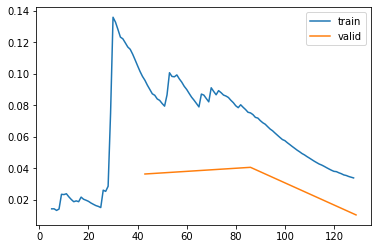

In [81]:
# validation에서 작동이 안 된다면 kernel을 shutdown한 다음 restart를 하자
learn.fit_one_cycle(3,
                   1e-4,
                   cbs=[SaveModelCallback()])
learn.recorder.plot_loss()
# 0.09 쯤이 가장 좋았다.

In [82]:
import os
root = '/workspace/dataset/sick/test/'

#!rm -rf /workspace/dataset/sick/dataset/*.ipynb_checkpoints
!rm -rf `find -type d -name .ipynb_checkpoints`

for folder in os.listdir(root):
    print(folder, img_data.class_to_idx[folder])
    for fname in os.listdir(root + folder):
        print(learn.predict(root + folder +"/"+fname), end = "")
    print("\n")

노균병 0


('0', tensor(0), tensor([0.4686, 0.0792, 0.0151, 0.3342, 0.1028]))

('0', tensor(0), tensor([0.6841, 0.0274, 0.0102, 0.2509, 0.0273]))

녹병 1


('1', tensor(1), tensor([0.0478, 0.9033, 0.0079, 0.0304, 0.0106]))

('1', tensor(1), tensor([0.2175, 0.6284, 0.0049, 0.1035, 0.0458]))

('1', tensor(1), tensor([0.2436, 0.6846, 0.0044, 0.0473, 0.0200]))

잿빛곰팡이병 3


('3', tensor(3), tensor([0.0223, 0.0049, 0.0126, 0.9514, 0.0088]))

('4', tensor(4), tensor([0.0649, 0.0167, 0.0154, 0.2420, 0.6610]))

정상 4


('4', tensor(4), tensor([0.0570, 0.0135, 0.0198, 0.0419, 0.8678]))

('4', tensor(4), tensor([0.3498, 0.0598, 0.1011, 0.1038, 0.3855]))

('4', tensor(4), tensor([0.2705, 0.0674, 0.1490, 0.1912, 0.3220]))

('4', tensor(4), tensor([0.0941, 0.0250, 0.0219, 0.0627, 0.7963]))

잎말이 2


('4', tensor(4), tensor([0.0276, 0.0048, 0.1131, 0.1457, 0.7087]))

('4', tensor(4), tensor([5.6276e-03, 6.5240e-04, 5.0335e-03, 1.0792e-02, 9.7789e-01]))



KeyError: '구멍'

In [77]:
learn.save('failLeafRoll')

Path('models/failLeafRoll.pth')